Text analysis of the FCC public commentary was performed in several ways. A sample of the full dataset was pulled for analysis using ~10% of the data (300,000 public comments) in the interest of analysis time. The text data was imported and processed for analysis including tokenizing and vectorizing the tweets. Kmeans clustering was used to evaluate what clusters exist in the text, which was followed by sentiment analysis.  

* [Import of packages and data](#section1)
* [Clean, Tokenize and Vectorize Text Data for Analysis](#section2)
* [Clustering - What are the top text clusters?](#section3)
* [Sentiment Analysis](#section4)

<a id='section1'></a>

### Import of Packages and Data

#### Import needed packages

In [15]:
import json
import numpy as np
import pandas as pd
import pylab as pl
import seaborn as sns
import re
import string
import nltk
from collections import Counter
stopwords = nltk.corpus.stopwords.words('english')
from nltk.collocations import BigramCollocationFinder, BigramAssocMeasures
from nltk.tokenize import TweetTokenizer
from sklearn.cluster import KMeans
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from sklearn.decomposition import NMF
from gensim import corpora, models
from collections import OrderedDict
from nltk.stem.wordnet import WordNetLemmatizer
from textblob import TextBlob

#### Import and prepare FCC data

In [2]:
fcc = pd.read_csv('~/Desktop/fcc_sample.csv', index_col='docid')

In [3]:
fcc.shape

(300000, 2)

<a id='section2'></a>

### Clean, Tokenize and Vectorize Text Data for Analysis

In [4]:
text = fcc.text_data.tolist()

In [31]:
stopwords = nltk.corpus.stopwords.words('english')
RE_stopwords = r'\b(?:{})\b'.format('|'.join(stopwords))

def clean_text(text_data):
    # Remove RT (retweet signal)
    text_data = re.sub('RT @', '@', text_data)
    # Remove tickers
    text_data = re.sub(r'\$\w*','', text_data)
    # Remove URLs
    text_data = re.sub(r'https?:\/\/.*\/\w*','', text_data)
    # Remove puncutation
    text_data = re.sub(r'[' + string.punctuation + ']+', ' ', text_data)
    # Remove stopwords
    text_data = re.sub(RE_stopwords, ' ', text_data)
    # Tokenize text
    tokenizer = TweetTokenizer(strip_handles=True, reduce_len=True)
    tokens = tokenizer.tokenize(text_data)
    # Remove stopwords and single characters
    tokens = [i.lower() for i in tokens if i not in stopwords and len(i) > 1]
    return tokens

In [32]:
cleaned_text = []
for text_data in text:
    cleaned_text.append(clean_text(text_data))

In [33]:
len(cleaned_text), len(fcc)

(300000, 300000)

In [34]:
fcc['cleaned_text'] = cleaned_text

In [35]:
cleaned_texts = fcc.cleaned_text.apply(lambda x: ' '.join(x))

In [36]:
vectorizer = TfidfVectorizer(use_idf=True, ngram_range=(1, 2))  
transformed = vectorizer.fit_transform(cleaned_texts.values)
features = vectorizer.get_feature_names()

In [37]:
transformed.shape

(300000, 1051724)

In [38]:
vectorizer2 = TfidfVectorizer(use_idf=True, ngram_range=(3, 4))  
transformed2 = vectorizer2.fit_transform(cleaned_texts.values)
features2 = vectorizer2.get_feature_names()

In [39]:
transformed2.shape

(300000, 4144498)

<a id='section3'></a>

### Clustering - What are the top text clusters?

#### Clusters with 1, 2 ngrams

In [41]:
n_clusters = 5

kmeans = KMeans(n_clusters=n_clusters, n_jobs=1)
kmeans.fit(transformed)
clusters = kmeans.labels_.tolist()
fcc['cluster_id'] = clusters

fcc.cluster_id.value_counts()

0    97974
2    87140
1    79247
3    18127
4    17512
Name: cluster_id, dtype: int64

In [42]:
# sort cluster centers by proximity to centroid
centroids_order = kmeans.cluster_centers_.argsort()[:, ::-1]

for i in range(n_clusters):
    print('\n\nTop terms in cluster {}:\n'.format(i))
    for idx in centroids_order[i, :10]:
        print('\t{}'.format(features[idx]))



Top terms in cluster 0:

	net
	neutrality
	net neutrality
	title
	strong
	strong net
	internet
	keep
	neutrality title
	ii


Top terms in cluster 1:

	isps
	pay
	lanes
	fcc
	able
	rules
	made
	chairman pai
	pai
	fast


Top terms in cluster 2:

	obama
	internet
	wheeler
	regulate
	take
	control
	it
	policy
	broadband
	internet access


Top terms in cluster 3:

	users
	internet
	internet users
	that
	certain
	ensure
	create internet
	right
	create
	protections


Top terms in cluster 4:

	the previous
	previous administration
	previous
	administration
	the
	internet
	regulate
	take
	control
	it


For this dataset, the clusters seem to focus on different aspects of net neutrality. Cluster 0 seems to be about keeping the internet strong with net neutrality, Cluster 1 pay lanes without net neutrality and the current FCC chair, Cluster 2 the former FCC chair under Obama and control, Cluster 3 internet user rights and protections, and Cluster 4 the previous administration.

#### Clusters with 3, 4 ngrams

In [43]:
n_clusters = 5

kmeans2 = KMeans(n_clusters=n_clusters, n_jobs=1)
kmeans2.fit(transformed2)
clusters2 = kmeans2.labels_.tolist()
fcc['cluster_id2'] = clusters2

fcc.cluster_id2.value_counts()

2    210834
1     41942
3     36495
0      9133
4      1596
Name: cluster_id2, dtype: int64

In [44]:
# sort cluster centers by proximity to centroid
centroids_order2 = kmeans2.cluster_centers_.argsort()[:, ::-1]

for i in range(n_clusters):
    print('\n\nTop terms in cluster {}:\n'.format(i))
    for idx in centroids_order2[i, :10]:
        print('\t{}'.format(features2[idx]))



Top terms in cluster 0:

	create internet fast
	create internet fast lanes
	internet users like sincerely
	users like sincerely
	technology users urge keep
	generations technology users urge
	technology users urge
	users urge keep title
	users urge keep
	providers slow block ability


Top terms in cluster 1:

	pay slow lanes
	net neutrality rules
	economy nmoreover chairman pai
	service ninternet providers able
	american economy nmoreover chairman
	economy nmoreover chairman
	abysmal customer service ninternet
	customer service ninternet providers
	service ninternet providers
	small ncourts made clear


Top terms in cluster 2:

	net neutrality it
	open internet it
	the obama wheeler
	the previous administration
	net neutrality title
	strong net neutrality
	neutrality title ii
	net neutrality title ii
	federal communications commission
	obama power grab


Top terms in cluster 3:

	pay slow lanes
	net neutrality rules
	small courts made
	small courts made clear
	large small courts made

With a larger ngram range, the clusters shift slightly but are still similar to previously.  Cluster 0 seems to about internet speed, Cluster 1 about customer service, Cluster 2 about strong net neutrality, Cluster 3 about hte court system, and cluster 4 about the FCC chair and the ruling to repeal.

### Topic Modeling

In [45]:
lemma = WordNetLemmatizer()

def lemmatize(text):
    return ' '.join(lemma.lemmatize(word) for word in text.split())

texts = [text for text in cleaned_texts.values if len(text) > 1]
lemmatized_texts = [lemmatize(text).split() for text in texts]

In [46]:
dictionary = corpora.Dictionary(lemmatized_texts)
terms_matrix = [dictionary.doc2bow(doc) for doc in lemmatized_texts]

In [53]:
ldamodel = models.ldamodel.LdaModel(
    terms_matrix, num_topics=10, id2word=dictionary, passes=5)

In [54]:
tfidf = models.TfidfModel(terms_matrix)
corpus_tfidf = tfidf[terms_matrix]
corpus_lda = ldamodel[corpus_tfidf]
total_topics = 5

In [55]:
data_lda = {i: OrderedDict(ldamodel.show_topic(i,15)) for i in range(total_topics)}

In [56]:
df_lda = pd.DataFrame(data_lda)
print(df_lda.shape)
df_lda = df_lda.fillna(0).T
print(df_lda.shape)

(45, 5)
(5, 45)


/Users/mollymcnamara/anaconda/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:106: MatplotlibDeprecationWarning: The axisbg attribute was deprecated in version 2.0. Use facecolor instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


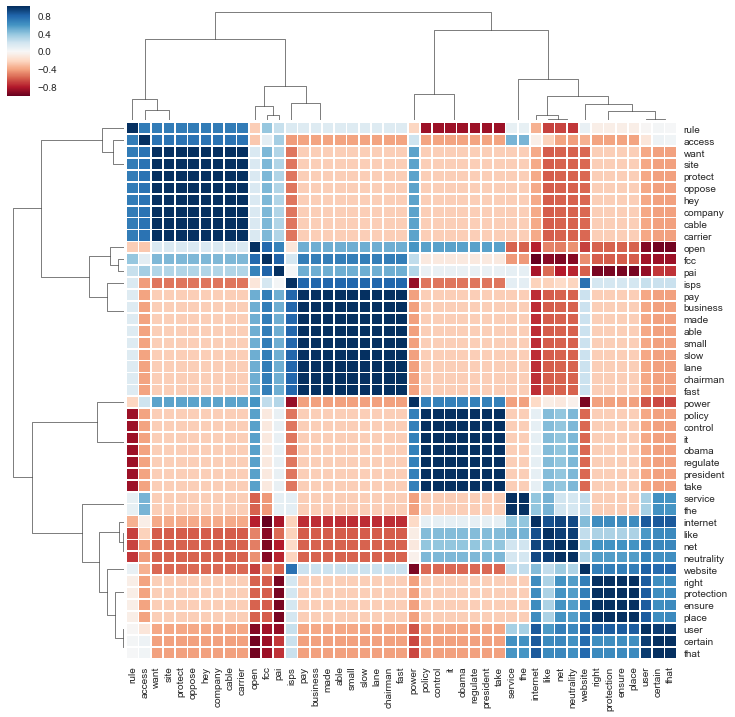

In [57]:
g=sns.clustermap(df_lda.corr(), center=0, cmap="RdBu", metric='cosine', linewidths=.75, figsize=(12, 12))
plt.setp(g.ax_heatmap.yaxis.get_majorticklabels(), rotation=0)
plt.show()

Mapping the topic model in this case gives some interesting ideas about the overlap in terms across this set of text.

<a id='section4'></a>

### Sentiment Analysis

#### Sentiment Analysis using TextBlob Pattern Analyzer

In [48]:
def get_sentiment(tweet):
    return TextBlob(tweet).sentiment.polarity

In [49]:
fcc['sentiment'] = fcc.cleaned_text.apply(lambda x: get_sentiment(' '.join(x)))

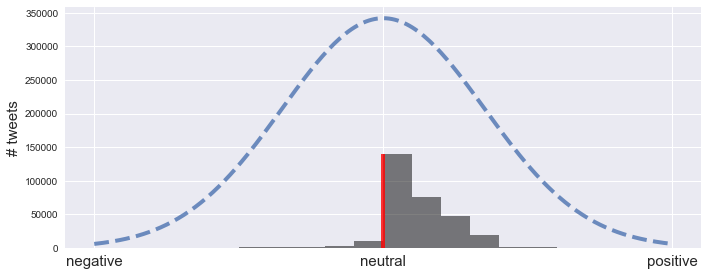

In [50]:
from scipy.stats import norm
hist, edges = np.histogram(fcc.sentiment.values, bins=np.arange(-1, 1, 0.1))
fig, ax = pl.subplots(figsize=(10,4))
fcc.sentiment.hist(ax=ax, bins=20, color='k', alpha=0.5)
# ax.bar(edges, hist, width=width, color='k', alpha=0.5)
ax.set_xticks(range(-1, 2))
ax.set_xticklabels(['negative', 'neutral', 'positive'], fontsize=15)
ax.set_ylabel('# tweets', fontsize=15)
x = np.arange(-1, 1, 0.01)
ax.plot(x, norm.pdf(x, 0, 0.35) * 300000, '--', linewidth=4, alpha=0.8)
ax.vlines(0, 0, 140000, color='r', linewidth=4, linestyle='-', alpha=0.8)
pl.tight_layout()
pl.show()

#### Most Negative Comments

In [51]:
for t in fcc[fcc.sentiment == fcc.sentiment.min()].text_data[:10]:
    print(t + '\n')

Please no, this is an awful idea which providers will take advantage of. Internet providers already have monopolies in some areas and this is against what capitalism is all for which is competition.

THIS IS A TERRIBLE IDEA.

Horrible decision

This is outrageous. Stop infringing on our rights.

We already have some of the worst service for the highest prices.

Don't do it. Don't be evil. Don't sell everyone out.

DO NOT let my ISP control what i see.
this is a terrible idea.

Don't pass these laws, they are a horrible idea.

It is outrageous that anyone would consider this.

Why would you want to limit the internet freedom? It is terrible!



#### Most Positive Comments

In [52]:
for t in fcc[fcc.sentiment == fcc.sentiment.max()].text_data[:10]:
    print(t + '\n')

The internet is for all of us, to do what we want with - don't take away the best of what we have

I think the internet is perfect the way it is

Consumers – not internet service providers – should pick which websites and apps are best.

Make the internet the best for everyone!

Keep access to the internet neutral. This is the best way to ensure the people of the United States stay informed, educated and competitive in the world.

This act is against the best interest of the people of the united states and is in favor of businesses and there for is a violation of the edicts the FCC was founded on.

Keep the greatest learning device ever created to flourish for all.

Regulations on internet providers are needed to preclude  practices that are not in the consumers/constituents best interest such as those that limit competition.

If the best features of the internet are no longer mine to choose, why would I want to stay in the computing world?

Keep the playing field level and investments

#### Note that in this dataset - comments to the FCC about the repeal of net neutrality - there are many positive-sentiment comments directed at supporting the repeal.  As noted in the data wrangling notebook for this project, this dataset has been noted to be heavily weighted with fake/bot posts supporting a net neutrality repeal.  These results fit with the prior findings and demonstrate the need to further investigate the text beyond simple sentiment polarity in order to understand the position of the comments.